### Do NOT click RUN ALL... or else you will spend 20 minutes redefining the embeddings

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from Bio.Seq import Seq
from transformers import TFBertModel, BertTokenizer,BertConfig
import re
import pickle
import sys
import gc
import os
import pdfplumber
import shutil
import glob
import math
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE
import random

# np.random.seed(42)
# tf.random.set_seed(42)
# os.environ['PYTHONHASHSEED']=str(42)
tf.keras.utils.set_random_seed(42)


# Defining

Code for ProtBERT and BFD

In [ ]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)

: 

In [ ]:
def get_embeddings(sequence_list):
    # tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )
    # embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)
    sequence_list = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequence_list]
    ids = tokenizer.batch_encode_plus(sequence_list, add_special_tokens=True, padding=True, return_tensors="tf")
    input_ids = ids['input_ids']
    attention_mask = np.asarray(ids['attention_mask'])
    embedding = np.asarray(embedding_model(input_ids)[0])
    print(np.shape(input_ids))
    average_embeddings = []
    for seq_num in range(len(embedding)):

        seq_len = (attention_mask[seq_num] == 1).sum()
        # seq_len = (len(attention_mask[seq_num]))
        residues = embedding[seq_num][1:seq_len-1]
        average = np.mean(residues, axis=0)
        average_embeddings.append(average)
    
    del residues
    del average
    del ids
    del sequence_list
    del embedding
    del input_ids
    del attention_mask
    gc.collect()

    return np.asarray(average_embeddings)

: 

In [ ]:
sequences_Example = ["A E T C Z A O","S K T Z P"] # REMEMBER SPACING

: 

In [ ]:
average_embeddings = get_embeddings(sequences_Example)
# print(residue_embeddings)

: 

In [ ]:
tf.__version__

: 

# Data Formatting

In [ ]:
# Read Heavy_Seqs

dummy = []
head = []
flag = False
with open("../Data/CLL/heavy_seqs.txt") as myfile:
    for i in myfile:
        dummy.append(i)
    for i in dummy:
        if flag == True:
            flag = False
            continue
        if i.find("light") != -1:
            flag = True
            continue
        if i.find(">") == -1 & i.find("-") == -1 & i.find("X") == -1:
            if (len(i) <= 145) & (len(i) >= 100):
                if i not in head:
                    head.append(i)
    np.random.shuffle(head)
print(head[:5], len(head))
cll_sequences = head

textual_sequences = list(dict.fromkeys(cll_sequences))

: 

In [ ]:
# Read JSAV
df = pd.read_csv("../Data/CLL/JSAV_Export.csv", skiprows=1)
df.drop(df.columns[[0, 1, 2, 3, 4, 5]], axis=1, inplace=True)
df.drop(["H52A", "H52B", "H52C", "H82A", "H82B", "H82C", "H100A", "H100B", "H100C", "H100D", "H100E", "H100F", "H100G", "H100H", "H100I", "H100J", "H100K", "H100L"], axis=1, inplace=True)
array = df.to_string(header=False, index=False, index_names=False).split('\n')
jsav_sequences = []
for i in array:
    if i.find(">") == -1 & i.find("-") == -1 & i.find("X") == -1:
        i = i.replace(" ", "")
        print(i)
        jsav_sequences.append(i)

: 

In [ ]:
# Read CSV
excel_sequences = []
## mini function but I'm too lazy to write it as one
df1 = pd.read_excel("../Data/CLL/CLL_Hydropathy.xlsx", skiprows=2)
df1 = df1[["IGHV Sequence"]]
df1 = df1.dropna()
temp_sequences = df1.to_numpy()
temp_sequences = [i for sub_list in temp_sequences for i in sub_list]
for i in temp_sequences:
    temp = Seq.translate(i.strip())
    excel_sequences.append(temp)
excel_sequences = [i for i in excel_sequences if i.find("*") == -1]
print(len(excel_sequences))
print(excel_sequences)

: 

In [ ]:
# need mass filtering, making sure between 100 and 138

cll_sequences = np.concatenate((textual_sequences, jsav_sequences, excel_sequences))

cll_sequences = list(dict.fromkeys(cll_sequences))
print(len(cll_sequences))
cll_sequences = [i for i in cll_sequences if len(i) >= 100]
print(len(cll_sequences))
# cll_sequences = [i for i in cll_sequences if len(i) <= 138]
# print(len(cll_sequences))
cll_sequences = [i for i in cll_sequences if i.find("X") == -1 if i.find("-") == -1]
print(len(cll_sequences))
np.random.shuffle(cll_sequences)

: 

In [ ]:
# shutil.copy("../Data/cll/heavy_seqs_aa.fasta", "../Data/cll/heavy_seqs_aa.txt")
# OR
# Run the following too when new download
# awk '/^>/ {printf("\n%s\n",$0);next; } { printf("%s",$0);}  END {printf("\n");}' < file.fa > out.txt
# Then, delete the first empty line

: 

In [ ]:
dummy = []
head = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for cll, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 138) & (len(aa_sequence) >= 100):
                head.append(aa_sequence)
                if len(head) >= 250:
                    break
print(head[:5], len(head))
healthy_sequences = head

: 

In [ ]:
# print(healthy_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(cll_sequences, key=len)))
print(len(healthy_sequences))
print(len(cll_sequences))
# print(cll_sequences)

: 

In [ ]:
del head
del myfile
del dummy
gc.collect()

: 

In [15]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

# Preprocessing

In [16]:
if os.path.exists('cll_binary_embeddings') == False:
    os.mkdir('cll_binary_embeddings')

In [17]:
number_param_cll = math.ceil(len(cll_sequences)/3000)

for i in range(number_param_cll):
    cll_sequences_new = [(" ".join(s)) for s in cll_sequences][round(len(cll_sequences) * (1/number_param_cll) * i):round(len(cll_sequences) * (1/number_param_cll) * (i+1))]
    cll_average_embeddings = get_embeddings(cll_sequences_new)

    with open("cll_binary_embeddings/cll_" + str(i) + ".pkl", "wb") as f:
        pickle.dump(cll_average_embeddings, f)

    del cll_sequences_new
    del cll_average_embeddings
    gc.collect()

(75, 144)


In [18]:
number_param_healthy = math.ceil(len(healthy_sequences)/3000)

for i in range(number_param_healthy):
    healthy_sequences_new = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * (1/number_param_healthy) * i):round(len(healthy_sequences) * (1/number_param_healthy) * (i+1))]
    healthy_average_embeddings = get_embeddings(healthy_sequences_new)

    with open("cll_binary_embeddings/healthy_" + str(i) + ".pkl", "wb") as f:
        pickle.dump(healthy_average_embeddings, f)
    f.close()

    del healthy_sequences_new
    del healthy_average_embeddings
    gc.collect()

(250, 133)


# Loading

In [2]:
cll_average_embeddings = [[None] * 1024]

In [3]:
number_param_cll = 1
for i in range(number_param_cll):
    with open("cll_binary_embeddings/cll_" + str(i) + ".pkl", "rb") as f:
        cll_temp = pickle.load(f)
        cll_average_embeddings = np.concatenate((cll_average_embeddings, cll_temp))
    f.close()

cll_average_embeddings = np.delete(cll_average_embeddings, 0, 0)

In [4]:
healthy_average_embeddings = [[None] * 1024]

In [5]:
number_param_healthy = 1
for i in range(number_param_healthy):
    with open("cll_binary_embeddings/healthy_" + str(i) + ".pkl", "rb") as f:
        healthy_temp = pickle.load(f)
        healthy_average_embeddings = np.concatenate((healthy_average_embeddings, healthy_temp))
    f.close()

healthy_average_embeddings = np.delete(healthy_average_embeddings, 0, 0)

In [6]:
print(healthy_average_embeddings.shape)

(250, 1024)


In [7]:
healthy_lables = [0] * 75 # 250
cll_lables = [1] * 75

# Visualization

In [8]:
from sklearn.manifold import TSNE
embeds = np.concatenate((cll_average_embeddings, healthy_average_embeddings[:250]))

In [9]:
%%time

tsne = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=10)
X_embedded = tsne.fit_transform(embeds)

CPU times: user 3.66 s, sys: 1.04 s, total: 4.7 s
Wall time: 1.41 s


In [ ]:
all_sequences = np.concatenate((cll_sequences, healthy_sequences[:250]))
disease_labels = ['CLL'] * 75 + ['Healthy'] * 250

In [25]:
df = pd.DataFrame()
df.insert(0, 't-SNE 1', X_embedded[:,0])
df.insert(1, 't-SNE 2', X_embedded[:,1])
df.insert(2, 'Sequence', all_sequences)
df.insert(3, 'Disease Label', disease_labels)
df

,t-SNE 1,t-SNE 2,Sequence,Disease Label
0,7.296477,-36.155716,QVQLVQSGAEVKNPGASVKVSCKASGYTFITYAMHWVRQAPGQRLE...,CLL
1,32.473263,7.692873,GGSLRLSCAASGFSFSDYDINWVRQAPGKGLEWVSGISGSGDSTYY...,CLL
2,-30.096914,-9.730415,EVQLVETGGGLVQPGKSLELTCATSGFIFNTAWMHWVRQSPDKRLE...,CLL
3,-13.649794,-34.558796,SQSVKESEGDLVTPAGNLTLTCTASGSDINDYPISWVRQAPGKGLE...,CLL
4,8.509829,-4.105756,SGGSLRLSCAASGFTFSDHYMDWVRQAPGKGLEWVGRIRTKARSYT...,CLL
...,...,...,...,...
320,27.757563,3.200309,EDQLVESGGGLVQPGESLTLSCVASGFTFSLYWMSWVRQAPGKGLE...,Healthy
321,-32.974010,2.867043,GSLRLSCTVSGGSISGYYWTWIRQPPGKGLEWVGYIFPSGSTNYNP...,Healthy
322,32.013103,0.858112,GSLRLSCAASGFSISGYWMNWVRQAPGKGLEWGATIKQDGSEKYYV...,Healthy
323,-41.571224,1.362382,TLSLTCTVSGYSISSGYYWGWIRQSTGQGLEWIASINHSGTSYYNP...,Healthy


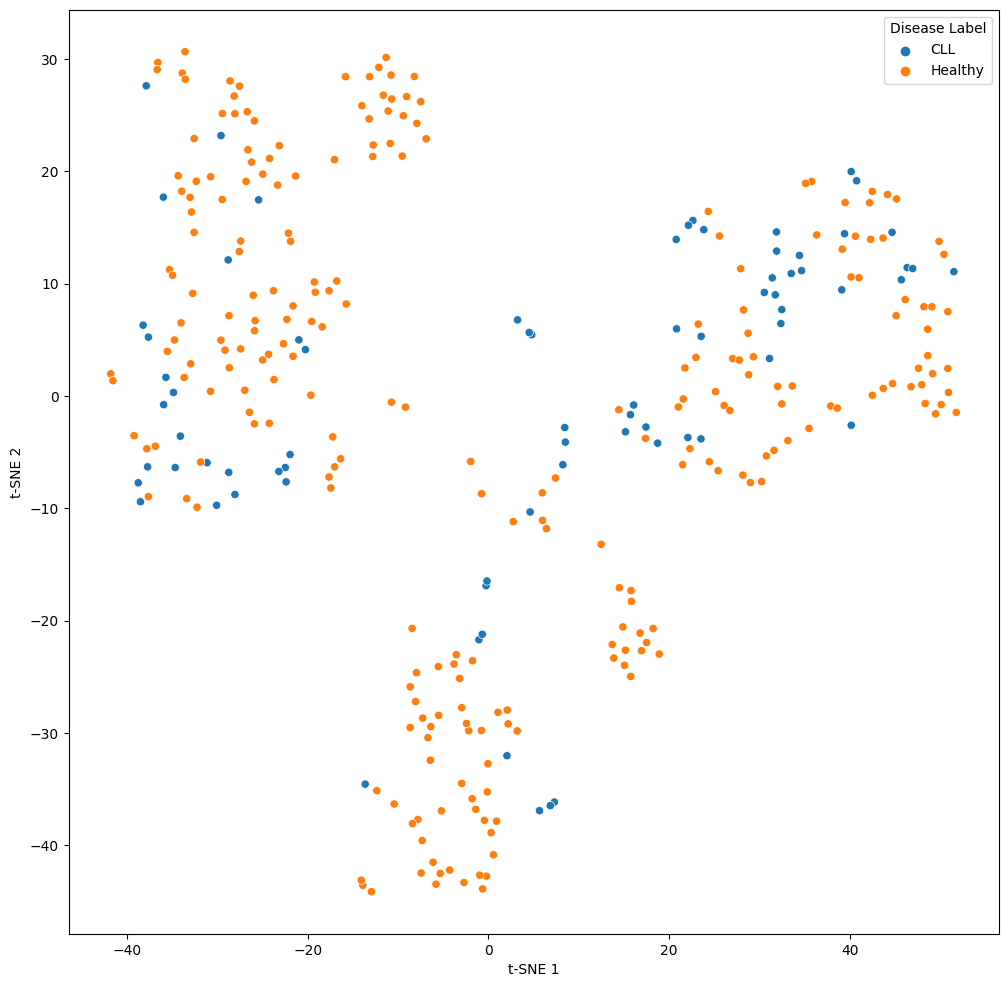

In [26]:
plt.figure(figsize=(12,12))
sns.scatterplot(
    x="t-SNE 1", y="t-SNE 2",
    hue="Disease Label",
    data=df,
    legend="full"
)
plt.show()

# Model 3: Averaging Embeddings

In [10]:
X = np.concatenate((healthy_average_embeddings[:75], cll_average_embeddings))
y = np.concatenate((healthy_lables, cll_lables))

In [11]:
del cll_average_embeddings
gc.collect()

52

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
print(len(X_train))
print(len(X_test))

120
30


In [14]:
print(len([i for i in y_test if i == 0]))
print(len([i for i in y_test if i == 1]))

16
14


In [15]:
# val_set = zip(X_val, y_val)
# new_y_val = []
# new_X_val = []
# count = 0
# for i in val_set:
#     if i[1] == 1:
#         new_X_val.append(i[0])
#         new_y_val.append(i[1])
#     if i[1] == 0 and count < 6:
#         new_X_val.append(i[0])
#         new_y_val.append(i[1])
#         count+=1

# c = list(zip(new_X_val, new_y_val))

# # random.shuffle(c)

# X_val, y_val = zip(*c)
# y_val = np.array(y_val)
# print(y_val)

In [16]:
# test_set = zip(X_test, y_test)
# new_y_test = []
# new_X_test = []
# count = 0
# for i in test_set:
#     if i[1] == 1:
#         new_X_test.append(i[0])
#         new_y_test.append(i[1])
#     if i[1] == 0 and count < 8:
#         new_X_test.append(i[0])
#         new_y_test.append(i[1])
#         count+=1

# c = list(zip(new_X_test, new_y_test))

# # random.shuffle(c)

# X_test, y_test = zip(*c)
# y_test = np.array(y_test)
# print(y_test)

In [17]:
X_train = np.concatenate((X_train, healthy_average_embeddings[94:]))
y_train = np.concatenate((y_train, [0] * len(healthy_average_embeddings[94:])))

In [18]:
for i in y_train:
    print(i)

0
0
0
0
0
1
0
0
0
0
1
1
1
0
0
1
1
1
1
1
1
1
0
0
1
0
0
0
0
0
1
0
0
0
1
0
1
1
0
1
1
0
1
1
0
1
1
0
0
1
1
0
0
1
1
0
1
0
0
0
1
1
1
1
1
1
0
0
1
1
0
0
0
0
1
0
1
1
0
0
0
1
0
1
0
1
0
1
1
0
1
0
0
1
0
1
1
1
0
0
1
1
0
1
0
0
1
1
1
1
1
0
1
1
0
0
1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [19]:
del X
del y
del healthy_average_embeddings
gc.collect()

0

### Using SMOTE

In [20]:
# print(len([i for i in y_train if i == 0]))
# sm = SMOTE(random_state=42, sampling_strategy=1.0)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print(X_train.shape)

### Using Borderline SMOTE

In [21]:
print(len([i for i in y_train if i == 0]))
sm = BorderlineSMOTE(random_state=42, sampling_strategy=1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(X_train.shape)

215
(430, 1024)


In [22]:
for i in y_train:
    print(i)

0
0
0
0
0
1
0
0
0
0
1
1
1
0
0
1
1
1
1
1
1
1
0
0
1
0
0
0
0
0
1
0
0
0
1
0
1
1
0
1
1
0
1
1
0
1
1
0
0
1
1
0
0
1
1
0
1
0
0
0
1
1
1
1
1
1
0
0
1
1
0
0
0
0
1
0
1
1
0
0
0
1
0
1
0
1
0
1
1
0
1
0
0
1
0
1
1
1
0
0
1
1
0
1
0
0
1
1
1
1
1
0
1
1
0
0
1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [23]:
c = list(zip(X_train, y_train))

random.shuffle(c)

X_train, y_train = zip(*c)
y_train = np.array(y_train)
for i in y_train:
    print(i)

1
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
1
0
1
1
0
0
1
0
0
1
0
0
0
0
0
1
1
1
0
0
0
0
0
1
1
0
1
1
1
0
1
0
1
0
1
1
0
0
0
0
1
1
0
1
1
0
1
1
0
1
0
0
0
0
0
0
1
1
0
0
0
0
0
0
1
1
1
1
1
0
1
0
0
0
0
1
1
0
1
1
0
0
1
1
1
0
0
1
0
0
0
1
1
0
0
1
0
1
0
0
1
0
1
0
0
1
0
1
1
1
0
0
1
1
1
0
0
1
0
0
0
0
0
1
0
1
0
1
1
0
1
1
1
1
1
0
1
0
1
1
1
1
1
0
1
0
0
0
1
0
0
0
0
1
1
0
0
1
1
0
0
1
0
0
1
1
0
0
0
0
1
0
1
0
0
1
1
0
1
0
0
0
0
1
1
1
1
1
1
0
1
0
1
1
0
1
1
1
1
0
0
1
1
1
0
0
1
0
1
1
1
1
1
0
1
0
0
1
0
1
1
0
0
0
1
0
1
1
1
0
0
0
1
1
0
0
0
1
0
0
0
1
1
0
0
0
0
0
0
1
1
1
0
1
0
0
0
1
0
1
0
0
1
1
1
1
1
0
1
1
0
0
0
0
0
0
1
1
0
1
1
1
0
0
0
1
1
0
1
0
1
0
0
1
0
1
1
0
0
0
0
1
1
1
1
0
0
0
0
1
0
0
0
1
1
1
0
1
0
1
1
0
1
1
1
1
1
0
1
1
0
0
1
0
1
0
1
1
0
1
1
0
1
1
0
0
1
0
1
0
1
1
0
1
1
0
1
0
0
1
0
0
1
0
0
1
0
1
1
0
1
0
1
0
1
1
1
1
0
0
1
0
1
0
1
1
1
1
1
1
0
1
0
1
0
0
1
1
0
1
0
1
1
1
0
1
0
0
0
0
1
1
0
1


### Model Evaluation

In [24]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')

In [25]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1024,)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(784, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(384, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(1024,)),
#   tf.keras.layers.Dense(1024, activation='relu'),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(16, activation='relu'),
#   # tf.keras.layers.Dense(8, activation='relu'),
#   # tf.keras.layers.Dense(4, activation='relu'),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model.summary()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-02-14 21:56:00.043939: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-14 21:56:00.044381: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 784)               803600    
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 384)               196992    
                                                                 
 dense_4 (Dense)             (None, 256)               9

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [27]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=50,
    mode='auto',
    restore_best_weights=True,
)

In [28]:
# With SMOTE
history = model.fit(X_train, y_train, epochs=500, validation_data = (X_test, y_test), callbacks=[es])

Epoch 1/500


2023-02-14 21:56:02.071720: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-14 21:56:02.404001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 78ms/step - loss: 0.6994 - accuracy: 0.5093 - val_loss: 0.6942 - val_accuracy: 0.4667
Epoch 2/500
 1/14 [=>............................] - ETA: 0s - loss: 0.6859 - accuracy: 0.4688

2023-02-14 21:56:03.885415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 21ms/step - loss: 0.6943 - accuracy: 0.5070 - val_loss: 0.6857 - val_accuracy: 0.5000
Epoch 3/500
14/14 [==============================] - 0s 23ms/step - loss: 0.6524 - accuracy: 0.6512 - val_loss: 0.5550 - val_accuracy: 0.7667
Epoch 4/500
14/14 [==============================] - 0s 29ms/step - loss: 0.4803 - accuracy: 0.7930 - val_loss: 0.4827 - val_accuracy: 0.7667
Epoch 5/500
14/14 [==============================] - 0s 27ms/step - loss: 0.3942 - accuracy: 0.8256 - val_loss: 0.7011 - val_accuracy: 0.8000
Epoch 6/500
14/14 [==============================] - 0s 16ms/step - loss: 0.4062 - accuracy: 0.8791 - val_loss: 0.4176 - val_accuracy: 0.8333
Epoch 7/500
14/14 [==============================] - 0s 22ms/step - loss: 0.2765 - accuracy: 0.9047 - val_loss: 0.4674 - val_accuracy: 0.8667
Epoch 8/500
14/14 [==============================] - 0s 24ms/step - loss: 0.3130 - accuracy: 0.8814 - val_loss: 0.3755 - val_accuracy: 0.9000
Epoch 9/500
14/14 

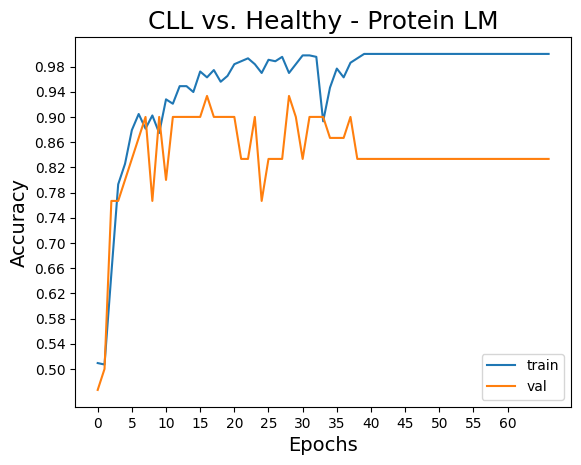

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CLL vs. Healthy - Protein LM', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.yticks(np.arange(0.5, 1.0, 0.04))
plt.xticks(np.arange(0, 65, 5.0))
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 3 Testing

In [29]:
model.save("cll_model.h5")

In [28]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 34ms/step - loss: 0.4092 - accuracy: 0.9333


[0.4091931879520416, 0.9333333969116211]

In [30]:
model = tf.keras.models.load_model("cll_model.h5")

In [31]:
y_pred = []
y_true = y_test

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 14ms/step


2023-01-26 20:01:06.389842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 17ms/step


[array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32)]

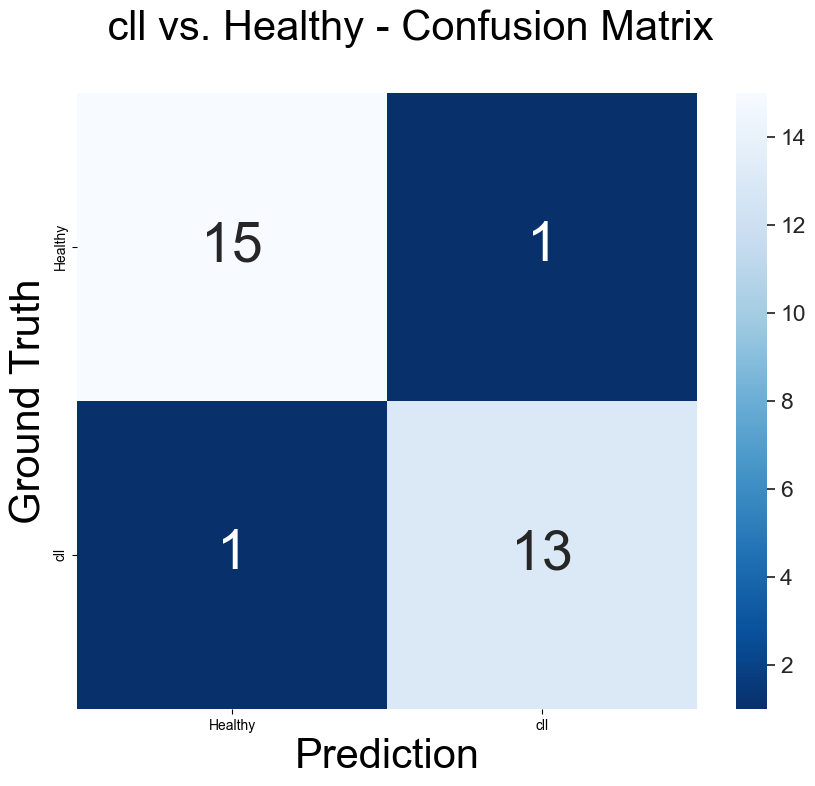

tf.Tensor(
[[15  1]
 [ 1 13]], shape=(2, 2), dtype=int32)


In [32]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
plt.title('    cll vs. Healthy - Confusion Matrix\n', fontsize=30)
sns.set(font_scale=1.5)

cmap = sns.color_palette("Blues_r", as_cmap=True)

sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "cll"],
            yticklabels=["Healthy", "cll"],
            annot=True, fmt='g', annot_kws={"size":40}, cmap=cmap)
plt.xlabel('Prediction', fontsize=30)
plt.ylabel('Ground Truth', fontsize=30)
plt.show()

print(confusion_mtx)

In [33]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

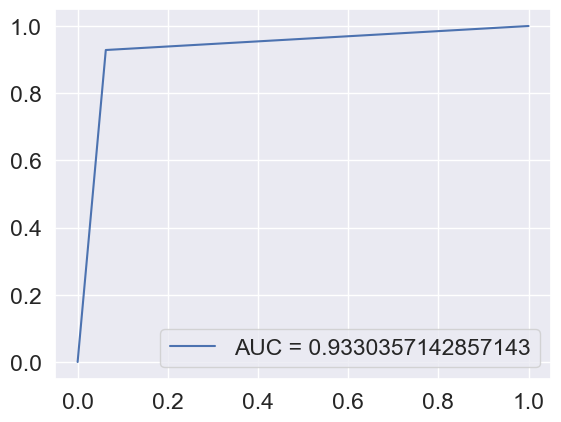

In [34]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()